# Overview

このノートで、

- 学習データ作成の概要
- LightGBM の概要

について議論する。

In [1]:
import os
import glob
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import scipy as sc
from sklearn.model_selection import KFold
import tqdm

import lightgbm as lgb
import warnings

warnings.filterwarnings('ignore')

# set options
pd.set_option('max_columns', 300)

## 目的

offer book と trade のデータを渡されて、次の time_id で target (=volatility)がどういう値を取るかを予測するコンペ。

In [2]:
# 学習用、正解データ
pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv').head()

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


- LightGVMに入力するデータは、何らかの１行のデータになっていなければならない（時系列データとはいうものの、扱うのは１行に収まっている形式のデータ）。
- 与えられている book_train, trade_train は time_id の中の時系列データになっている
    - そのため LightGBMの入力に使用するには、まとめることが必要
- そのため、注目している銘柄、time_id の動向を代表するような統計情報（mean, std, etc）を作る必要がある。

#データ作成

## book_train

- 行で時系列を表現しているデータ → 学習用データとするには、stock_id と time_id でユニークな主キーを作るような形式にしないとダメ
    - 時系列性をどのような数量で表現するかを考える必要がある
- offer book, trade data を最終的に train.csv の内容とマージする必要がある
    - target を正解ラベル、その他（stock_id, time_id, row_idを除く）を入力情報とした学習を行う

In [3]:
book_train = pd.read_parquet("../input/optiver-realized-volatility-prediction/book_train.parquet/stock_id=0")
book_train.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100


例えば以下のような操作をすると、stock_id と time_id を混ぜた `row_id` が定義できて、これを用いると、train.csv とマージできる

In [4]:
book_train['row_id'] = book_train['time_id'].apply(lambda x: f'0-{x}')
book_train.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,row_id
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100,0-5
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,0-5
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,0-5
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0-5
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0-5


### train.csv と book_train とのマージ

入力データを作成する概要は次の通り

- train.csv の読み込み
    - row_id の作成
- book_train.csv の読み込み
    - row_id の作成
    - このままでは row_id は主キーではないので、groupbyをして、ユニークな値とする
- 主キーを `row_id` にして両テーブルを結合する

このようにして作成したデータは１行１入力データとして LightGBMで使用することができる。**ただし**、stock_id, time_id, row_id はリークを招く情報なので削除する。

In [5]:
train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
train['row_id'] = train['stock_id'].astype(str)  + '-' + train['time_id'].astype(str) 

book_train = pd.read_parquet("../input/optiver-realized-volatility-prediction/book_train.parquet/stock_id=0")
book_train['row_id'] = book_train['time_id'].apply(lambda x : f'0-{x}')
book_train = book_train.groupby('row_id').mean()

train = train.merge(book_train, on = ['row_id'], how = 'left')
train.head()

,stock_id,time_id_x,target,row_id,time_id_y,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,0,5,0.004136,0-5,5.0,293.241722,1.003314,1.004169,1.003139,1.004320,78.264901,74.579470,80.880795,89.771523
1,0,11,0.001445,0-11,11.0,332.590000,1.000011,1.000406,0.999870,1.000541,149.965000,71.145000,95.445000,94.895000
2,0,16,0.002168,0-16,16.0,253.712766,0.999204,0.999929,0.999007,1.000127,96.132979,131.037234,114.526596,74.654255
3,0,31,0.002195,0-31,31.0,268.791667,0.998445,0.999304,0.998255,0.999413,114.458333,120.800000,68.783333,131.225000
4,0,62,0.001747,0-62,62.0,292.909091,0.999407,0.999804,0.999216,0.999913,119.823864,88.477273,87.840909,47.079545


ちなみに、book_train は row_id で groupbyしているので、reset_index しておかないと、それがインデックスのままになっているので注意。

In [6]:
book_train.reset_index(inplace=True)
book_train

,row_id,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,0-1000,1000.0,299.134146,0.998618,0.999061,0.998467,0.999232,80.926829,92.621951,44.128049,72.737805
1,0-10000,10000.0,251.244755,0.999686,1.000146,0.999527,1.000266,76.552448,86.695804,112.090909,94.178322
2,0-10005,10005.0,292.277174,1.000190,1.002297,0.999822,1.002565,91.679348,79.760870,66.369565,95.135870
3,0-10017,10017.0,266.407895,0.995274,0.998812,0.994699,0.999658,65.245614,126.179825,94.293860,93.618421
4,0-10030,10030.0,271.881443,0.999215,0.999838,0.999078,1.000118,80.768041,114.345361,61.840206,68.716495
...,...,...,...,...,...,...,...,...,...,...,...
3825,0-9972,9972.0,289.804781,1.001464,1.002238,1.001088,1.002385,101.800797,45.860558,53.011952,70.414343
3826,0-9973,9973.0,302.683502,0.997702,0.999753,0.997552,1.000271,148.693603,118.747475,73.548822,105.680135
3827,0-9976,9976.0,297.374101,0.993438,0.995737,0.993206,0.995841,124.323741,640.388489,95.417266,232.402878
3828,0-9988,9988.0,311.679167,0.999989,1.000689,0.999900,1.000858,93.812500,95.016667,56.662500,86.866667


## 並列化

今回のデータセットを扱う際の一つのボトルネックは、データ数の大さと、stock_id毎にファイルが分割されていることである。これを処理するために、まず簡単に `Parallel` 関数を使用する。この関数は、処理を並列化させることができる。

ex. 数値を10倍にする関数があり、これをリストで与えられたデータに対して適用したいとする。これを並列化させる場合は以下のように書く

- n_jobs ：使用するスレッド数。-1指定でシステムの全てのスレッドを使用する

返り値は、与えられたリストと同じ次元数の計算結果を含んだリスト。

In [7]:
%%time

data_list = [1,2,3,4,5]

def process(num):
    big_num = num*10
    return big_num

export_data_list = Parallel(n_jobs=-1, verbose=-1)(delayed(process)(num) for num in data_list)
export_data_list

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


CPU times: user 49.4 ms, sys: 67.3 ms, total: 117 ms
Wall time: 936 ms


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


[10, 20, 30, 40, 50]

これを使って処理させる。ユニークな stock_id を引っ張ってきてそれをリストとして与える。

In [27]:
%%time

data_dir = '../input/optiver-realized-volatility-prediction/'

train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
train['row_id'] = train['stock_id'].astype(str)  + '-' + train['time_id'].astype(str) 

def pp_book(file):
    df = pd.read_parquet(file)
    df['row_id'] = df['time_id'].apply(lambda x : f'0-{x}')
    df = df.groupby('row_id').mean()
    df = df.reset_index()
    return df


def pp_trade(file):
    df = pd.read_parquet(file)
    df['row_id'] = df['time_id'].apply(lambda x : f'0-{x}')
    df = df.groupby('row_id').mean()
    df = df.reset_index()
    return df


def for_joblib(stock_id):

    file_path_book = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
    file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)

    # Preprocess book and trade data and merge them
    df_tmp = pd.merge(pp_book(file_path_book), pp_trade(file_path_trade), on = 'row_id', how = 'left')

    # Return the merge dataframe
    return df_tmp

# Use parallel api to call paralle for loop
list_stock_ids = train['stock_id'].unique()
df_train_trade = Parallel(n_jobs = -1, verbose = 0)(delayed(for_joblib)(stock_id) for stock_id in tqdm.tqdm(list_stock_ids))
# Concatenate all the dataframes that return from Parallel
df_train_trade = pd.concat(df_train_trade, ignore_index = True)

100%|██████████| 112/112 [01:41<00:00,  1.10it/s]


CPU times: user 2.82 s, sys: 696 ms, total: 3.52 s
Wall time: 1min 50s


In [28]:
df_train_trade.head()

,row_id,time_id_x,seconds_in_bucket_x,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,time_id_y,seconds_in_bucket_y,price,size,order_count
0,0-1000,1000.0,299.134146,0.998618,0.999061,0.998467,0.999232,80.926829,92.621951,44.128049,72.737805,1000.0,279.800000,0.998908,30.000000,2.133333
1,0-10000,10000.0,251.244755,0.999686,1.000146,0.999527,1.000266,76.552448,86.695804,112.090909,94.178322,10000.0,245.458333,0.999931,80.833333,2.916667
2,0-10005,10005.0,292.277174,1.000190,1.002297,0.999822,1.002565,91.679348,79.760870,66.369565,95.135870,10005.0,273.137931,1.001232,81.482759,3.137931
3,0-10017,10017.0,266.407895,0.995274,0.998812,0.994699,0.999658,65.245614,126.179825,94.293860,93.618421,10017.0,313.309524,0.996374,89.738095,3.166667
4,0-10030,10030.0,271.881443,0.999215,0.999838,0.999078,1.000118,80.768041,114.345361,61.840206,68.716495,10030.0,300.266667,0.999314,98.100000,2.333333


In [29]:
train = train.merge(df_train_trade, on = ['row_id'], how = 'left')
train.head()

,stock_id,time_id,target,row_id,time_id_x,seconds_in_bucket_x,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,time_id_y,seconds_in_bucket_y,price,size,order_count
0,0,5,0.004136,0-5,5.0,293.241722,1.003314,1.004169,1.003139,1.004320,78.264901,74.579470,80.880795,89.771523,5.0,326.025000,1.003722,79.475000,2.750000
1,0,5,0.004136,0-5,5.0,297.786087,1.003313,1.003980,1.003201,1.004089,62.173913,110.916522,54.212174,60.386087,5.0,312.670213,1.003740,106.468085,3.319149
2,0,5,0.004136,0-5,5.0,299.977702,1.001369,1.001497,1.001287,1.001585,159.238422,176.060034,241.029160,173.238422,5.0,299.943396,1.001424,180.754717,3.314465
3,0,5,0.004136,0-5,5.0,286.729412,0.999444,1.000122,0.999329,1.000272,116.641176,107.680392,101.831373,76.231373,5.0,242.546218,0.999969,239.546218,5.201681
4,0,5,0.004136,0-5,5.0,298.344304,1.002544,1.003323,1.002335,1.003438,90.263291,73.792405,68.850633,83.093671,5.0,288.793651,1.003115,79.126984,3.047619


## 入力形式

In [30]:
train.drop(['stock_id', 'row_id', 'time_id', 'time_id_x', 'time_id_y'], axis = 1)

,target,seconds_in_bucket_x,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,seconds_in_bucket_y,price,size,order_count
0,0.004136,293.241722,1.003314,1.004169,1.003139,1.004320,78.264901,74.579470,80.880795,89.771523,326.025000,1.003722,79.475000,2.750000
1,0.004136,297.786087,1.003313,1.003980,1.003201,1.004089,62.173913,110.916522,54.212174,60.386087,312.670213,1.003740,106.468085,3.319149
2,0.004136,299.977702,1.001369,1.001497,1.001287,1.001585,159.238422,176.060034,241.029160,173.238422,299.943396,1.001424,180.754717,3.314465
3,0.004136,286.729412,0.999444,1.000122,0.999329,1.000272,116.641176,107.680392,101.831373,76.231373,242.546218,0.999969,239.546218,5.201681
4,0.004136,298.344304,1.002544,1.003323,1.002335,1.003438,90.263291,73.792405,68.850633,83.093671,288.793651,1.003115,79.126984,3.047619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
854029,0.003461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
854030,0.003113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
854031,0.004070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
854032,0.003357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# LightGBM による学習

In [20]:
# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# Function to early stop with root mean squared percentage error
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

In [33]:
# Hyperparammeters (just basic)
params = {
  'objective': 'rmse',  
  'boosting_type': 'gbdt',
  'num_leaves': 100,
  'n_jobs': -1,
  'learning_rate': 0.1,
  'feature_fraction': 0.8,
  'bagging_fraction': 0.8,
  'verbose': -1,
}

# Split features and target
x = train.drop(['row_id', 'time_id', 'time_id_x', 'time_id_y', 'target', ], axis = 1)
y = train['target']

# Transform stock id to a numeric value
x['stock_id'] = x['stock_id'].astype(int)

# Create out of folds array
oof_predictions = np.zeros(x.shape[0])

# Create a KFold object
kfold = KFold(n_splits = 5, random_state = 66, shuffle = True)

# Iterate through each fold
for fold, (trn_ind, val_ind) in enumerate(kfold.split(x)):
    print(f'Training fold {fold + 1}')

    x_train, x_val = x.iloc[trn_ind], x.iloc[val_ind]
    y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
    # Root mean squared percentage error weights
    train_weights = 1 / np.square(y_train)
    val_weights = 1 / np.square(y_val)
    
    train_dataset = lgb.Dataset(x_train, y_train, weight = train_weights, categorical_feature = ['stock_id'])
    val_dataset = lgb.Dataset(x_val, y_val, weight = val_weights, categorical_feature = ['stock_id'])
    
    model = lgb.train(params = params, 
                      train_set = train_dataset, 
                      valid_sets = [train_dataset, val_dataset], 
                      num_boost_round = 10000, 
                      early_stopping_rounds = 50, 
                      verbose_eval = 50,
                      feval = feval_rmspe)
    
    # Add predictions to the out of folds array
    oof_predictions[val_ind] = model.predict(x_val)

rmspe_score = rmspe(y, oof_predictions)
print(f'Our out of folds RMSPE is {rmspe_score}')


Training fold 1
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.00100212	training's RMSPE: 0.427803	valid_1's rmse: 0.00101371	valid_1's RMSPE: 0.432838
[100]	training's rmse: 0.000989749	training's RMSPE: 0.42252	valid_1's rmse: 0.00100884	valid_1's RMSPE: 0.430759
[150]	training's rmse: 0.000982385	training's RMSPE: 0.419377	valid_1's rmse: 0.00100764	valid_1's RMSPE: 0.430245
[200]	training's rmse: 0.000976867	training's RMSPE: 0.417021	valid_1's rmse: 0.00100723	valid_1's RMSPE: 0.43007
Early stopping, best iteration is:
[195]	training's rmse: 0.000977368	training's RMSPE: 0.417235	valid_1's rmse: 0.00100721	valid_1's RMSPE: 0.43006
Training fold 2
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.00100218	training's RMSPE: 0.427883	valid_1's rmse: 0.00101323	valid_1's RMSPE: 0.432397
[100]	training's rmse: 0.000989784	training's RMSPE: 0.422592	valid_1's rmse: 0.00100792	valid_1's RMSPE: 0.430134
[150]	trainin

# モデルの評価

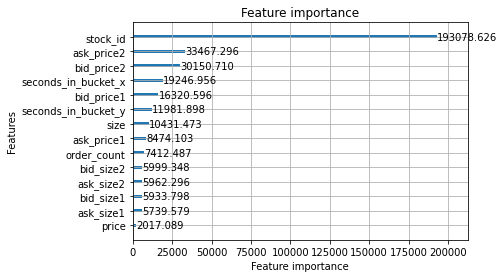

In [34]:
lgb.plot_importance(model, importance_type='gain')

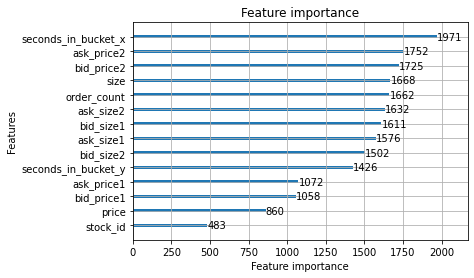

In [35]:
lgb.plot_importance(model)